# Import libraries

In [62]:
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve, make_scorer, RocCurveDisplay, average_precision_score, precision_score, f1_score, confusion_matrix
from mpl_toolkits import mplot3d
from BaselineRemoval import BaselineRemoval
from sklearn.decomposition import PCA
from pathlib import Path
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from time import time
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint, uniform
from sklearn.naive_bayes import GaussianNB

# Data exploration and pre-processing

## Load training data

In [3]:
data = pd.read_csv("dataset\\training.csv")
display(data)

# Check if there is any NaN value in the dataframe -> if NaN are present in the dataset, output is equal to True

print("Is there any NaN value in the dataframe?", data.isnull().any().any())

,Subject,Experimenter,Group,Group_cat,400,402,405,407,410,412,...,2100,2101,2103,2104,2105,2107,2108,2109,2111,2112
0,sub_003,exp_003,COVID-19,1.0,0,-0.020007,-0.034043,-0.037416,-0.037838,-0.035341,...,-0.000604,0.000035,0.001021,0.002459,0.001929,0.001884,0.003010,0.003254,0.002451,0.000000e+00
1,sub_094,exp_003,Healthy,0.0,0,-0.016014,-0.035603,-0.046161,-0.051559,-0.049918,...,-0.000771,0.000237,0.000698,0.002080,0.001340,0.001016,0.002005,0.001030,0.000544,0.000000e+00
2,sub_019,exp_003,COVID-19,1.0,0,-0.017834,-0.027070,-0.029060,-0.028674,-0.023619,...,-0.001663,-0.000475,0.000422,0.000025,0.000514,0.001926,0.002321,0.002154,0.001188,0.000000e+00
3,sub_055,exp_003,Healthy,0.0,0,-0.023746,-0.053267,-0.068881,-0.073029,-0.073602,...,-0.002083,-0.001443,0.000317,0.000891,0.001183,0.001435,0.000900,0.000314,0.000923,-5.550000e-18
4,sub_041,exp_003,COVID-19,1.0,0,-0.012517,-0.027595,-0.037434,-0.037509,-0.036196,...,-0.003165,-0.001553,-0.000490,0.000015,0.000345,0.000647,0.000776,0.000488,0.000028,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,sub_038,exp_003,COVID-19,1.0,0,-0.013458,-0.021313,-0.023163,-0.021093,-0.017599,...,-0.001712,-0.000770,0.000085,0.000628,0.000474,0.001050,0.001557,0.001485,0.001236,0.000000e+00
57,sub_100,exp_003,Healthy,0.0,0,-0.019288,-0.040023,-0.051999,-0.057813,-0.056117,...,-0.001819,-0.000211,0.000799,0.000773,0.001504,0.001892,0.002371,0.001466,0.000858,0.000000e+00
58,sub_031,exp_003,COVID-19,1.0,0,-0.008241,-0.012619,-0.012083,-0.010797,-0.007622,...,-0.001309,-0.000220,0.001086,0.001617,0.002072,0.002670,0.002493,0.001964,0.001017,0.000000e+00
59,sub_049,exp_003,COVID-19,1.0,0,-0.012507,-0.018218,-0.020317,-0.017332,-0.017216,...,-0.001353,-0.000529,0.000473,0.000294,0.000660,0.001322,0.002489,0.000978,-0.000793,0.000000e+00


Is there any NaN value in the dataframe? False


## Check for proportions of Covid/non-Covid subjects in dataframe

In [4]:
print("Number of subjects:", np.shape(data)[0])
target_count = data["Group_cat"].value_counts()
print("Number of Covid-19 patients:", target_count[1])
print("Number of healthy patients:", target_count[0])
print("Proportion between non-Covid/Covid: 1 : ", round(target_count[0] / target_count[1], 2))

Number of subjects: 61
Number of Covid-19 patients: 31
Number of healthy patients: 30
Proportion between non-Covid/Covid: 1 :  0.97


## Remove features that should not influence the prediction

In [5]:
dataset_training = data.drop(labels = ["Subject", "Experimenter", "Group", "Group_cat"], axis=1)
dataset_training.head()

,400,402,405,407,410,412,415,417,420,422,...,2100,2101,2103,2104,2105,2107,2108,2109,2111,2112
0,0,-0.020007,-0.034043,-0.037416,-0.037838,-0.035341,-0.033939,-0.035828,-0.035809,-0.034811,...,-0.000604,0.000035,0.001021,0.002459,0.001929,0.001884,0.003010,0.003254,0.002451,0.000000e+00
1,0,-0.016014,-0.035603,-0.046161,-0.051559,-0.049918,-0.047081,-0.044195,-0.042745,-0.041565,...,-0.000771,0.000237,0.000698,0.002080,0.001340,0.001016,0.002005,0.001030,0.000544,0.000000e+00
2,0,-0.017834,-0.027070,-0.029060,-0.028674,-0.023619,-0.019205,-0.020774,-0.023982,-0.025541,...,-0.001663,-0.000475,0.000422,0.000025,0.000514,0.001926,0.002321,0.002154,0.001188,0.000000e+00
3,0,-0.023746,-0.053267,-0.068881,-0.073029,-0.073602,-0.070267,-0.068547,-0.073332,-0.074415,...,-0.002083,-0.001443,0.000317,0.000891,0.001183,0.001435,0.000900,0.000314,0.000923,-5.550000e-18
4,0,-0.012517,-0.027595,-0.037434,-0.037509,-0.036196,-0.033654,-0.031637,-0.033729,-0.033926,...,-0.003165,-0.001553,-0.000490,0.000015,0.000345,0.000647,0.000776,0.000488,0.000028,0.000000e+00


## Let's plot some data

In [6]:
dataset_training_np = dataset_training.to_numpy()
dataset_training_np.shape

(61, 900)

### Let's take a closer look on the first four plots in the dataframe

<Figure size 640x480 with 0 Axes>

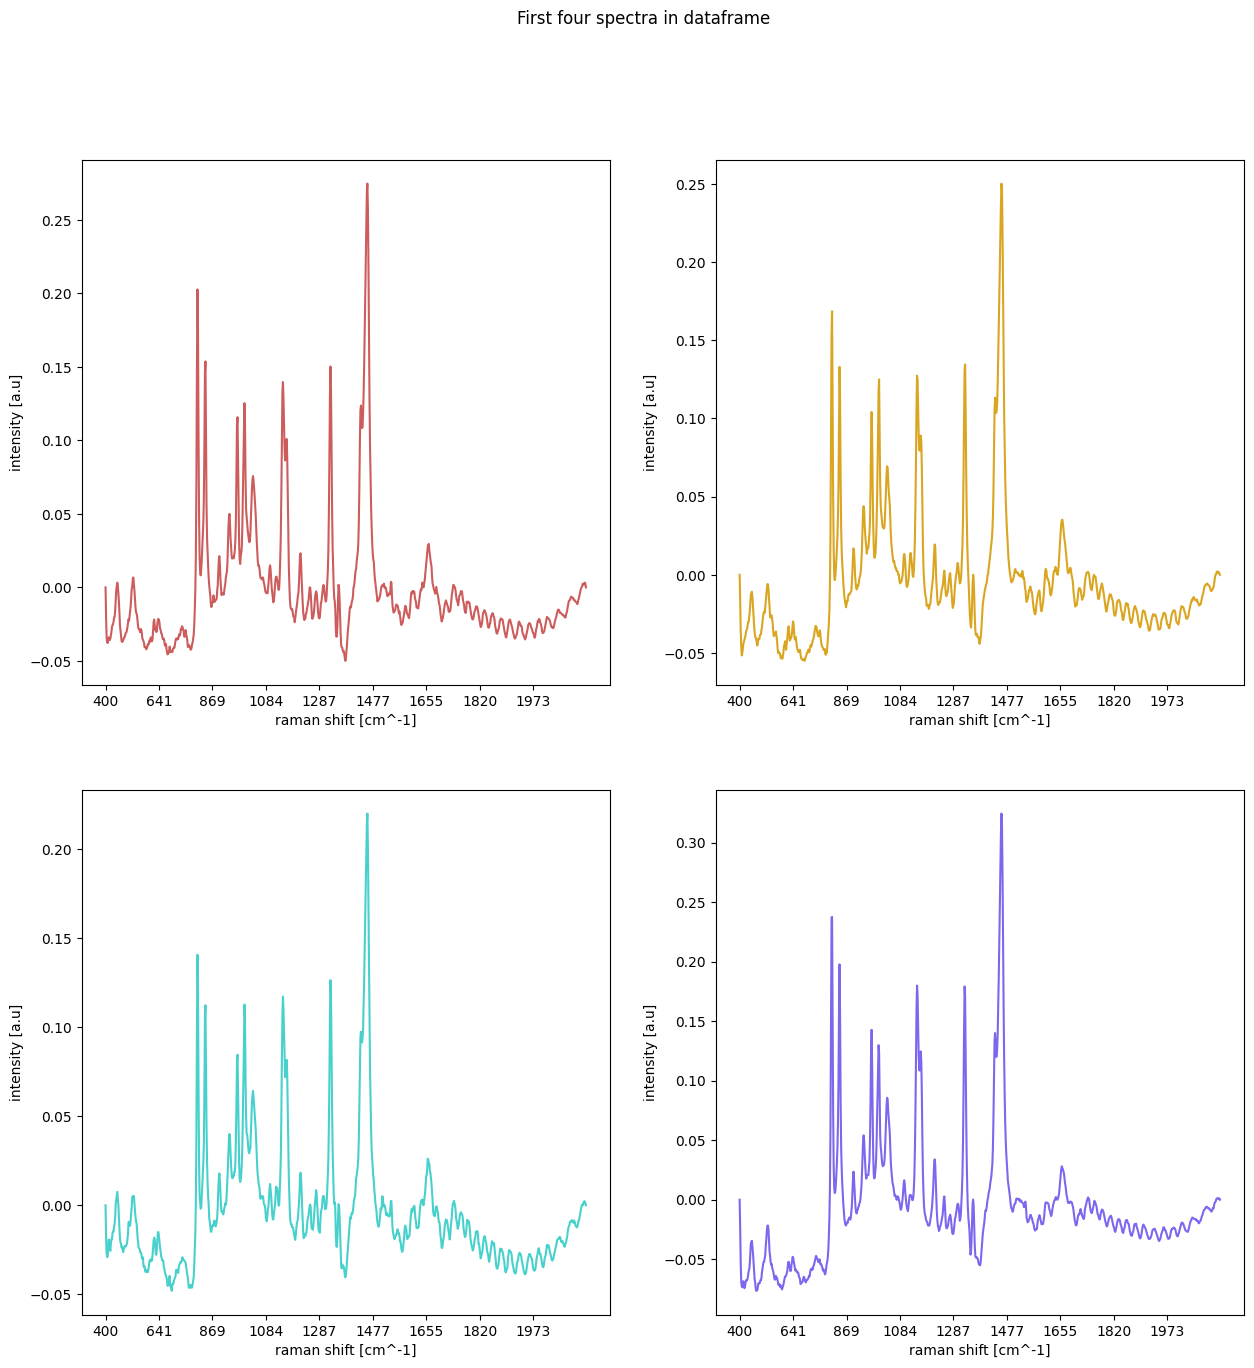

In [8]:
colors = ["indianred", "goldenrod", "mediumturquoise", "mediumslateblue"]
first_four_spectra = [dataset_training_np[i,:] for i in range(4)]
raman_shift = dataset_training.columns
plt.figure()
fig, axs = plt.subplots(2,2, figsize=(15,15))
fig.suptitle("First four spectra in dataframe")

for i, (spectrum, ax) in enumerate(zip(first_four_spectra, axs.ravel())):
    ax.plot(raman_shift, spectrum, colors[i])
    ax.set(xlabel="raman shift [cm^-1]", ylabel="intensity [a.u]")
    ax.set_xticks(np.arange(0, len(raman_shift), 100))

### Let's plot a spectrum of a covid patient vs a spectrum of a non-covid patient to see the differences

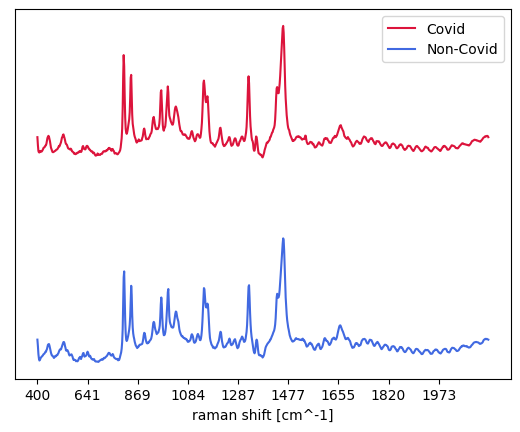

In [9]:
plt.figure()
plt.plot(raman_shift, dataset_training_np[0,:] + 0.5, "crimson", label="Covid")
plt.plot(raman_shift, dataset_training_np[1,:], "royalblue", label="Non-Covid")
plt.legend()
ax = plt.gca()
ax.set(xlabel="raman shift [cm^-1]")
ax.set_xticks(np.arange(0, len(raman_shift), 100))
ax.axes.yaxis.set_visible(False)

## Let's pre-process the data

From the plots above we can notice that the provided spectra show some inconstinces:

* some spectra present negative values, which does not make sense on a physical point of view. To solve this issue, it is necessary to perform baseline correction. We use the Zhang Fit method present in the `BaselineRemoval` package available in python; 

* the information before Raman shift ~ 550 cm^-1 and after Raman shift ~ 1700 cm^-1 resemble noise more than spectral information, therefore we decide to keep the signal in this range, removing the noisy information;

* finally, we standardize the data between 0 and 1

In [15]:
processed_spetra = []

for i in range(dataset_training_np.shape[0]):
    spectrum = dataset_training_np[i,:]
    baseline_obj = BaselineRemoval(spectrum)
    baseline_spectrum = baseline_obj.ZhangFit()
    baseline_cut = baseline_spectrum[79:643] #values chosen based on inspection of data
    norm_spectrum = (baseline_cut - baseline_cut.min())/(baseline_cut.max() - baseline_cut.min())
    processed_spetra.append(norm_spectrum)

cut_columns = raman_shift[79:643]
processed_dataframe = pd.DataFrame(processed_spetra)
processed_dataframe.columns = cut_columns
processed_dataframe.head()

WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!


,591,593,596,598,601,603,605,608,610,612,...,1711,1713,1714,1716,1718,1719,1721,1723,1724,1726
0,0.014267,0.013003,0.015881,0.022382,0.019793,0.027678,0.030174,0.026584,0.022318,0.028144,...,0.080069,0.087457,0.095682,0.099279,0.102997,0.098815,0.094095,0.091231,0.088573,0.079323
1,0.004581,0.000419,0.007960,0.014533,0.028813,0.031050,0.038741,0.031991,0.020531,0.034277,...,0.090482,0.100804,0.107340,0.104275,0.106755,0.103165,0.096775,0.088947,0.081455,0.085031
2,0.013807,0.018995,0.027107,0.037186,0.042161,0.044036,0.043865,0.041535,0.045884,0.056035,...,0.092411,0.103229,0.118023,0.123104,0.129114,0.125990,0.127128,0.118659,0.112097,0.103301
3,0.000000,0.002171,0.006682,0.010091,0.017475,0.022117,0.027709,0.027880,0.029115,0.034435,...,0.079737,0.083873,0.085891,0.084864,0.091628,0.096240,0.090547,0.086429,0.080969,0.077640
4,0.002718,0.003607,0.014830,0.028302,0.032673,0.032698,0.037152,0.036170,0.035324,0.039615,...,0.103280,0.113451,0.118041,0.120366,0.128868,0.126635,0.117301,0.111492,0.103192,0.106269


### Let's plot the processed data

In [16]:
processed_data_np = processed_dataframe.to_numpy()

<Figure size 640x480 with 0 Axes>

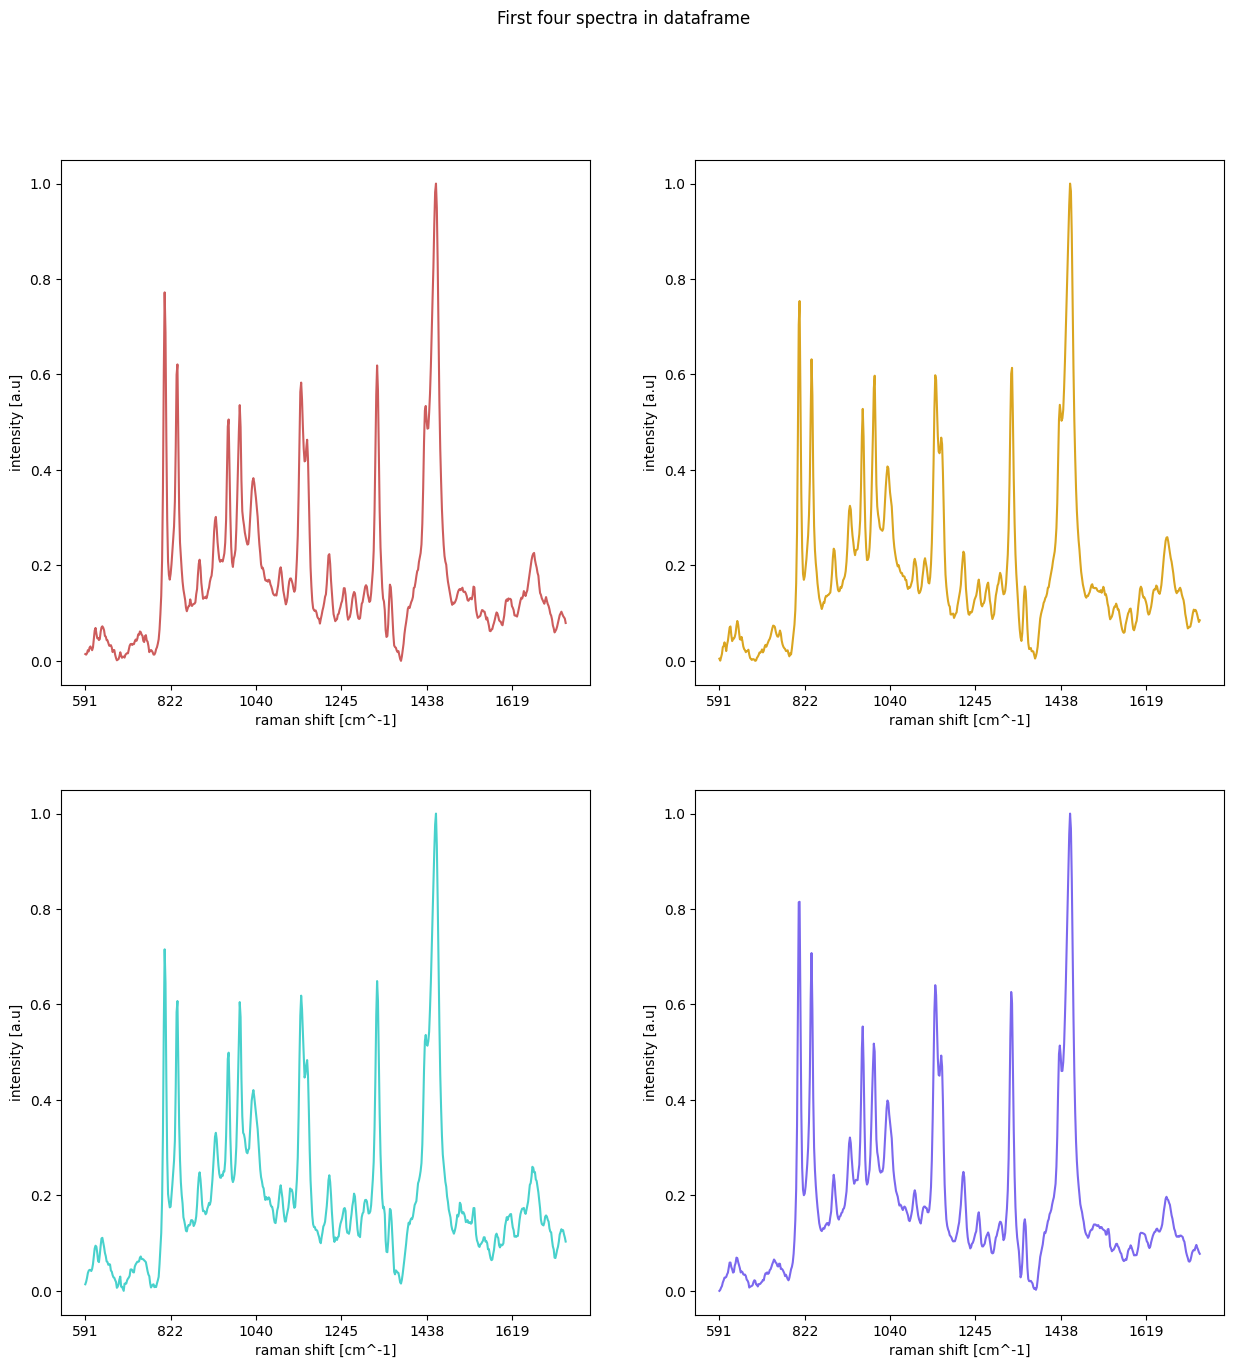

In [18]:
colors = ["indianred", "goldenrod", "mediumturquoise", "mediumslateblue"]
first_four_spectra = [processed_data_np[i,:] for i in range(4)]
raman_shift_cut = processed_dataframe.columns
plt.figure()
fig, axs = plt.subplots(2,2, figsize=(15,15))
fig.suptitle("First four spectra in dataframe")

for i, (spectrum, ax) in enumerate(zip(first_four_spectra, axs.ravel())):
    ax.plot(raman_shift_cut, spectrum, colors[i])
    ax.set(xlabel="raman shift [cm^-1]", ylabel="intensity [a.u]")
    ax.set_xticks(np.arange(0, len(raman_shift_cut), 100))

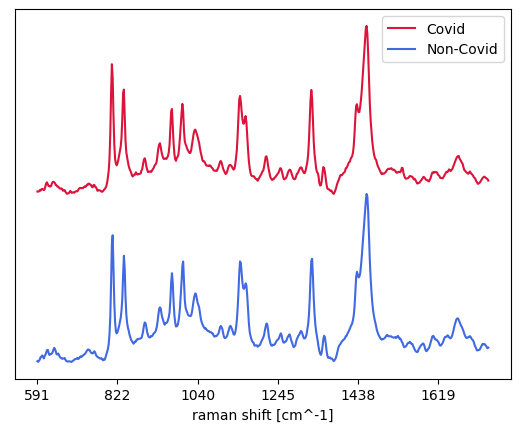

In [20]:
plt.figure()
plt.plot(raman_shift_cut, processed_data_np[0,:] + 1, "crimson", label="Covid")
plt.plot(raman_shift_cut, processed_data_np[1,:], "royalblue", label="Non-Covid")
plt.legend()
ax = plt.gca()
ax.set(xlabel="raman shift [cm^-1]")
ax.set_xticks(np.arange(0, len(raman_shift_cut), 100))
ax.axes.yaxis.set_visible(False)

## Principal component analysis

The number of features present in the dataframe is too high, in particular with respect to the number of subjects in the dataframe. It is probable that many of these feature are redundant and feeding them to the model would hinder its performance. Therefore, we perform the Principal Component Analysis (PCA) to reduce the number of features. We select the components that explain 95% of the variance present in our data.

In [24]:
X = processed_dataframe
y = data["Group_cat"]
pca = PCA(.95).fit(X)
X_transform = pca.transform(X)

In [27]:
# Let's save fitted PCA

ROOT = Path.cwd()
save_files = ROOT / "saved_files"

if not save_files.is_dir():
    save_files.mkdir(parents=True, exist_ok=True)

pca_file = save_files / "pca.joblib"
dump(pca, pca_file)

['c:\\Users\\WitApp\\Desktop\\datathon_covid\\saved_files\\pca.joblib']

In [28]:
components = pd.DataFrame(pca.fit_transform(X))
components.head()

,0,1,2,3,4
0,-0.516580,-0.017431,0.115709,0.192517,-0.094954
1,-0.232656,-0.122107,-0.043652,-0.213386,-0.060447
2,0.038443,-0.025058,-0.019825,0.181967,0.027518
3,-0.515097,-0.337816,0.284392,-0.051144,0.073847
4,0.314110,-0.239532,-0.066337,-0.087413,0.015721


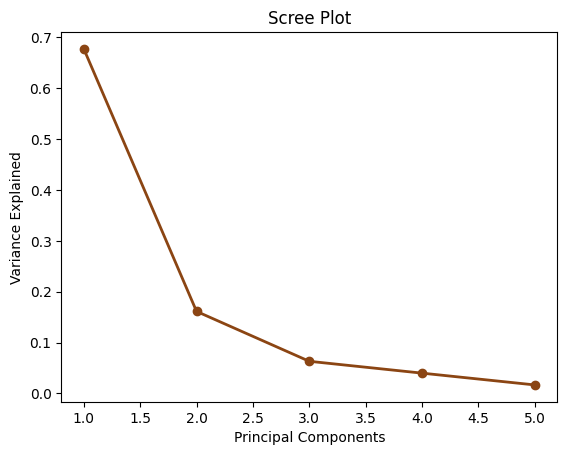

In [30]:
n_components = np.arange(pca.n_components_) + 1
plt.figure()
plt.plot(n_components, pca.explained_variance_ratio_, 'o-', linewidth=2, color='saddlebrown')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.show()

array([[<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>],
       [<AxesSubplot: title={'center': '2'}>,
        <AxesSubplot: title={'center': '3'}>],
       [<AxesSubplot: title={'center': '4'}>, <AxesSubplot: >]],
      dtype=object)

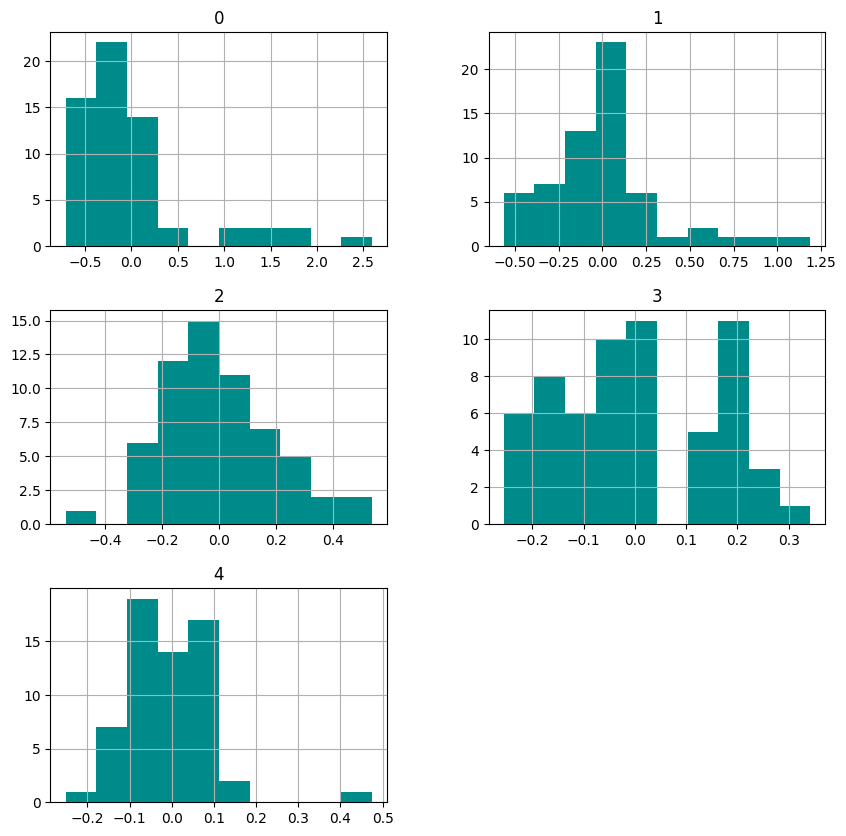

In [34]:
components.hist(color="darkcyan",figsize=(10,10))

# Model selection

We perform a randomized search cross-validation to select the best model

### Evaluation fanctions

In [40]:
# Function that returns the threshold corresponding to the closest point to (0,1) on the ROC curve 
def find_best_th_roc(ytrain, temp_ytrain_hat):
    fpr_train, tpr_train, th_roc_train = roc_curve(ytrain, temp_ytrain_hat)
    best_point_roc_x = np.array([0] * fpr_train.shape[0])
    #print('best_point_roc_x', best_point_roc_x)
    best_point_roc_y = np.array([1] * tpr_train.shape[0])
    #print('best_point_roc_y', best_point_roc_y)
    temp_x = (fpr_train - best_point_roc_x)
    temp_y = (tpr_train - best_point_roc_y)
    temp_sqrt = np.sqrt(np.square(temp_x) + np.square(temp_y))
    index_min_temp_sqrt = np.argmin(temp_sqrt)
    best_th_roc = th_roc_train[index_min_temp_sqrt]
    RocCurveDisplay.from_predictions(ytrain, temp_ytrain_hat)
    plt.scatter(fpr_train[th_roc_train == best_th_roc], tpr_train[th_roc_train == best_th_roc])
    plt.legend(['ROC curve', 'Best thr'])
    plt.show()
    return best_th_roc

# Function that returns the classifier performance metrics
def clf_metrics(y, y_score, y_pred, phase):
    AUROC = roc_auc_score(y, y_score)
    ACC = accuracy_score(y, y_pred)
    SENS = recall_score(y, y_pred, pos_label=1)
    SPEC = recall_score(y, y_pred, pos_label=0)
    AVE_PREC = average_precision_score(y, y_score)
    PREC = precision_score(y, y_pred)
    F1 = f1_score(y, y_pred)
    print('### ' + phase + ' set performances with the best threshold ###')
    print('AUROC', AUROC)
    print('Accuracy', ACC)
    print('Sensitivity', SENS)
    print('Specificity', SPEC)
    print('Average precision', AVE_PREC)
    print('Precision', PREC)
    print('F1 score', F1)

## Support Vector Machine

In [54]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
clf_svm = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, scoring='accuracy', n_jobs=-1, cv=cv, n_iter=500, verbose=3, random_state=1
)
clf_svm = clf_svm.fit(X_transform, y)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_svm.best_estimator_)

Fitting the classifier to the training set
Fitting 15 folds for each of 500 candidates, totalling 7500 fits
done in 4.783s
Best estimator found by grid search:
SVC(C=1965.6753051200317, class_weight='balanced', gamma=0.00018924123965722244)


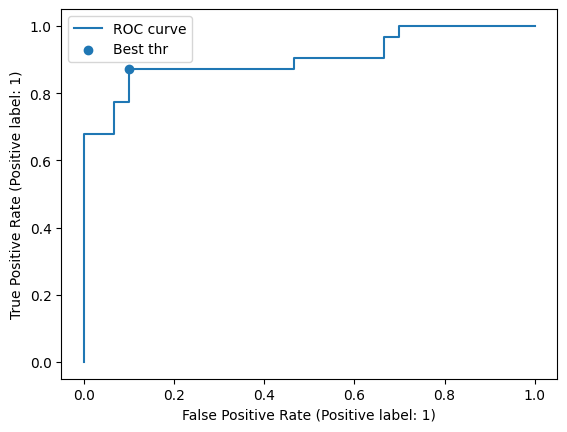

Best thr -0.03892699151829471
### TRAINING set performances with the best threshold ###
AUROC 0.903225806451613
Accuracy 0.8852459016393442
Sensitivity 0.8709677419354839
Specificity 0.9
Average precision 0.9323809582017113
Precision 0.9
F1 score 0.8852459016393444


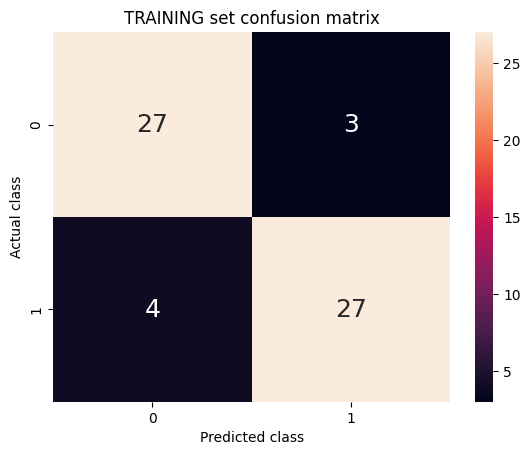

In [55]:
y_train_score = clf_svm.decision_function(X_transform)

ytrain = y.to_numpy()
best_th_pr = find_best_th_roc(ytrain, y_train_score)
print("Best thr", best_th_pr)
y_train_pred = (y_train_score >= best_th_pr).astype(int)
clf_metrics(y, y_train_score, y_train_pred, 'TRAINING')

CM = confusion_matrix(y, y_train_pred) # (tn, fp, fn, tp)
plt.figure()
ax = sns.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g') # font size
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('TRAINING set confusion matrix')
plt.show()

## Logistic regression

In [52]:
# define search space
print("Fitting the classifier to the training set")
t0 = time()
model = LogisticRegression()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
clf_log = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, verbose=3, random_state=1)

clf_log = clf_log.fit(X_transform, y)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_log.best_estimator_)

Fitting the classifier to the training set
Fitting 15 folds for each of 500 candidates, totalling 7500 fits
done in 4.342s
Best estimator found by grid search:
LogisticRegression(C=9.644630612025534)


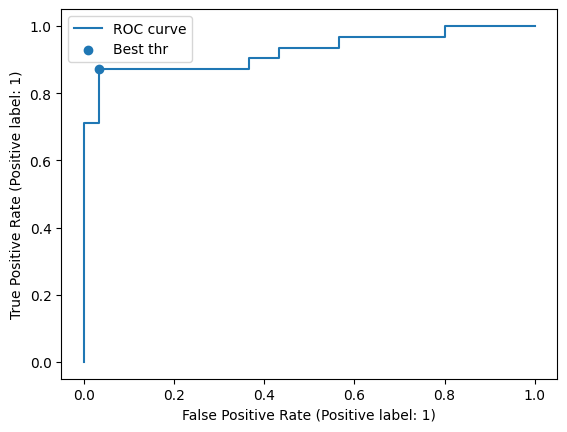

Best thr 0.05908136283745476
### TRAINING set performances with the best threshold ###
AUROC 0.924731182795699
Accuracy 0.9180327868852459
Sensitivity 0.8709677419354839
Specificity 0.9666666666666667
Average precision 0.9489509553716828
Precision 0.9642857142857143
F1 score 0.9152542372881356


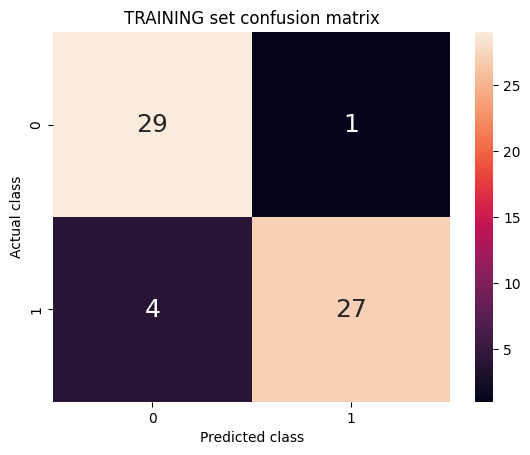

In [53]:
y_train_score = clf_log.decision_function(X_transform)

ytrain = y.to_numpy()
best_th_pr = find_best_th_roc(ytrain, y_train_score)
print("Best thr", best_th_pr)
y_train_pred = (y_train_score >= best_th_pr).astype(int)
clf_metrics(y, y_train_score, y_train_pred, 'TRAINING')

CM = confusion_matrix(y, y_train_pred) # (tn, fp, fn, tp)
plt.figure()
ax = sns.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g') # font size
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('TRAINING set confusion matrix')
plt.show()

## Multi-layer perceptron

In [59]:
# define search space
print("Fitting the classifier to the training set")
t0 = time()
model = MLPClassifier()
parameter_space = {
    'hidden_layer_sizes': [(sp_randint.rvs(100,600,1),sp_randint.rvs(100,600,1),), 
                                          (sp_randint.rvs(100,600,1),)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': uniform(0.0001, 0.9),
    'learning_rate': ['constant','adaptive']}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
clf_mlp = RandomizedSearchCV(model, parameter_space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, verbose=3, random_state=1)

clf_mlp = clf_mlp.fit(X_transform, y)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_mlp.best_estimator_)

Fitting the classifier to the training set
Fitting 15 folds for each of 500 candidates, totalling 7500 fits
done in 385.487s
Best estimator found by grid search:
MLPClassifier(activation='tanh', alpha=0.7808657106152417,
              hidden_layer_sizes=(139,), learning_rate='adaptive',
              solver='lbfgs')


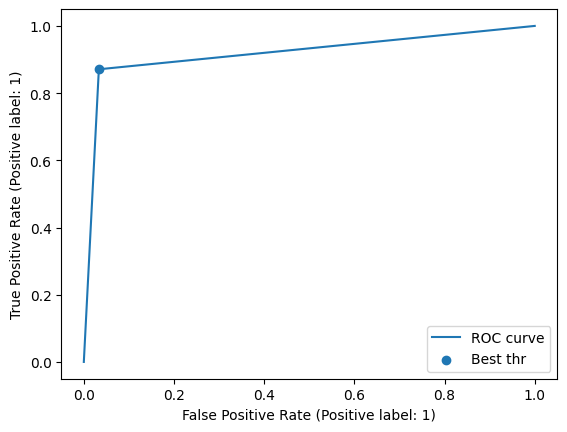

Best thr 1.0
### TRAINING set performances with the best threshold ###
AUROC 0.9188172043010754
Accuracy 0.9180327868852459
Sensitivity 0.8709677419354839
Specificity 0.9666666666666667
Average precision 0.905435521643877
Precision 0.9642857142857143
F1 score 0.9152542372881356


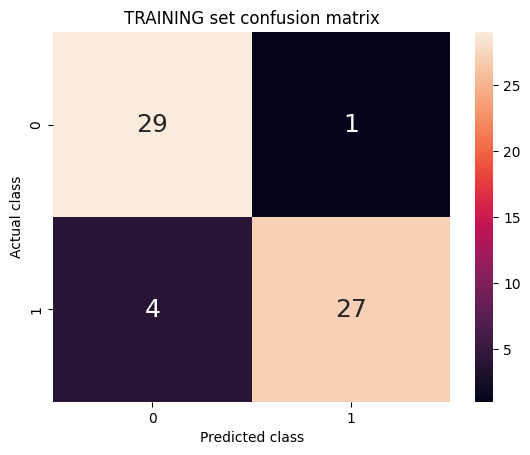

In [61]:
y_train_score = clf_mlp.predict(X_transform)

ytrain = y.to_numpy()
best_th_pr = find_best_th_roc(ytrain, y_train_score)
print("Best thr", best_th_pr)
y_train_pred = (y_train_score >= best_th_pr).astype(int)
clf_metrics(y, y_train_score, y_train_pred, 'TRAINING')

CM = confusion_matrix(y, y_train_pred) # (tn, fp, fn, tp)
plt.figure()
ax = sns.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g') # font size
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('TRAINING set confusion matrix')
plt.show()